# Description

The notebook compares the data from the `RawDataReader` and `HistoricalDataSource` with that from the production DAG.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
from typing import List

import pandas as pd

import core.finance as cofinanc
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.data.client.im_raw_data_client as imvcdcimrdc
import im_v2.common.universe as ivcu
import im_v2.common.universe.universe_utils as imvcuunut

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-a15b5d7b-cf1b-42dd-977e-dc61144b7a06.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4275_check_ohlcv_timing_issue'
  hash='d0d992b07'
  # Last commits:
    * d0d992b07 PomazkinG checkpoint                                                        (13 minutes ago) Mon May 1 18:28:54 2023  (HEAD -> CmTask4275_check_ohlcv_timing_issue, origin/CmTask4275_check_ohlcv_timing_issue)
    * 678a3d571 PomazkinG checkpoint                                                        (    3 days ago) Fri Apr 28 17:11:01 2

# Config

In [4]:
system_log_dir = "/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230419/system_log_dir.scheduled.20230419_041000.20230419_100500"
bar_duration = "5T"
universe_version = "v7.1"
# UTC timestamps. Use lookback to get the full bar, where 1 bar consists of five 1-minute rows.
start_timestamp_UTC = pd.Timestamp(
    "2023-04-19 04:10:00", tz="UTC"
) - pd.Timedelta(minutes=4)
_LOG.info("start_timestamp_UTC=%s", start_timestamp_UTC)
end_timestamp_UTC = pd.Timestamp("2023-04-19 08:05:00", tz="UTC")
_LOG.info("end_timestamp_UTC=%s", end_timestamp_UTC)
# ET timestamps.
start_timestamp_ET = start_timestamp_UTC.tz_convert("America/New_York")
_LOG.info("start_timestamp_ET=%s", start_timestamp_ET)
end_timestamp_ET = end_timestamp_UTC.tz_convert("America/New_York")
_LOG.info("end_timestamp_ET=%s", end_timestamp_ET)

INFO  start_timestamp_UTC=2023-04-19 04:06:00+00:00
INFO  end_timestamp_UTC=2023-04-19 08:05:00+00:00
INFO  start_timestamp_ET=2023-04-19 00:06:00-04:00
INFO  end_timestamp_ET=2023-04-19 04:05:00-04:00


In [5]:
def _print_df_info(df: pd.DataFrame) -> None:
    """
    Print basic stats about a DataFrame.
    """
    _LOG.info(
        "min_timestamp=%s, max_timestamp=%s", df.index.min(), df.index.max()
    )
    _LOG.info("columns=%s", hprint.list_to_str(df.columns.levels[0]))
    _LOG.info("assets=%s", hprint.list_to_str(df.columns.levels[1]))


def resample_ohlcv_bars(
    df_ohlcv: pd.DataFrame, bar_duration: str
) -> pd.DataFrame:
    """
    Resample 1-minute data to `bar_duration`.
    """
    # Resample.
    resampling_node = dtfcore.GroupedColDfToDfTransformer(
        "resample",
        transformer_func=cofinanc.resample_bars,
        **{
            "in_col_groups": [
                ("open",),
                ("high",),
                ("low",),
                ("close",),
                ("volume",),
            ],
            "out_col_group": (),
            "transformer_kwargs": {
                "rule": bar_duration,
                "resampling_groups": [
                    ({"close": "close"}, "last", {}),
                    ({"high": "high"}, "max", {}),
                    ({"low": "low"}, "min", {}),
                    ({"open": "open"}, "first", {}),
                    (
                        {"volume": "volume"},
                        "sum",
                        {"min_count": 1},
                    ),
                    (
                        {
                            "close": "twap",
                        },
                        "mean",
                        {},
                    ),
                ],
                "vwap_groups": [
                    ("close", "volume", "vwap"),
                ],
            },
            "reindex_like_input": False,
            "join_output_with_input": False,
        },
    )
    resampled_ohlcv = resampling_node.fit(df_ohlcv)["df_out"]
    return resampled_ohlcv

# Load DAG data

In [6]:
# Get bar timestamps grid. Round up to the nearest bar as DAG saves data every bar.
timestamps = pd.date_range(
    start_timestamp_ET.ceil(bar_duration),
    end_timestamp_ET.ceil(bar_duration),
    freq=bar_duration,
)
_LOG.info("timestamp_min=%s, timestamp_max=%s", timestamps[0], timestamps[-1])
dag_data_dir = os.path.join(system_log_dir, "dag", "node_io", "node_io.data")
_LOG.info("dag_data_dir=%s", dag_data_dir)

INFO  timestamp_min=2023-04-19 00:10:00-04:00, timestamp_max=2023-04-19 04:05:00-04:00
INFO  dag_data_dir=/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230419/system_log_dir.scheduled.20230419_041000.20230419_100500/dag/node_io/node_io.data


In [7]:
node_name = "predict.0.read_data"
dfs = []
for timestamp in timestamps:
    curr_df = dtfcore.get_dag_node_output(dag_data_dir, node_name, timestamp)
    bar_duration_int = int(bar_duration.strip("T"))
    curr_df = curr_df.sort_index(ascending=True)
    # Resolution is 1 minute for the `read_data` node, load the last 5 rows to get
    # the full bar.
    curr_df = curr_df.tail(bar_duration_int)
    dfs.append(curr_df)
dag_read_data_df_out = pd.concat(dfs)
_print_df_info(dag_read_data_df_out)
dag_read_data_df_out.head(3)

INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (10) close end_download_timestamp full_symbol high id knowledge_timestamp low open start_timestamp volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                                   end_download_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                       1030828978                       1464553467                       1467591036                       1528092593                       1776791608                       1891737434                       1966583502                       2099673105                       2237530510                       2384892553                       2425308589                       2476706208                       2484635488                       2540896331                       2601760471                       2683705052                       3065029174                       3401245610                       4516629366                       5115052901                       5118394986   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-19 00:06:00-04:00     0.3940    2089.71    30184.7     0.2263      5.620      6.843     0.5255      1.672     24.582     2.2934     0.4012      1.065     0.1342      9.301      8.536     1.1705    0.09276      3.138     0.6936     0.8340     0.5268      4.459     21.026     341.11       2.33 2023-04-19 04:06:10.003943+00:00 2023-04-19 04:06:10.003449+00:00 2023-04-19 04:06:10.003572+00:00 2023-04-19 04:06:10.005163+00:00 2023-04-19 04:06:10.004445+00:00 2023-04-19 04:06:10.004376+00:00 2023-04-19 04:06:10.005287+00:00 2023-04-19 04:06:10.005101+00:00 2023-04-19 04:06:10.005596+00:00 2023-04-19 04:06:10.005359+00:00 2023-04-19 04:06:10.003873+00:00 2023-04-19 04:06:10.005026+00:00 2023-04-19 04:06:10.005476+00:00 2023-04-19 04:06:10.005422+00:00 2023-04-19 04:06:10.004841+00:00 2023-04-19 04:06:10.004228+00:00 2023-04-19 04:06:10.005536+00:00 2023-04-19 04:06:10.004300+00:00 2023-04-19 04:06:10.003653+00:00 2023-04-19 04:06:10.006615+00:00 2023-04-19 04:06:10.004955+00:00   
2023-04-19 00:07:00-04:00     0.3939    208

In [8]:
node_name = "predict.2.resample"
dfs = []
for timestamp in timestamps:
    curr_df = dtfcore.get_dag_node_output(dag_data_dir, node_name, timestamp)
    # Resolution = `bar_duration` so load only the last row.
    curr_df = curr_df.sort_index(ascending=True)
    curr_df = curr_df.tail(1)
    dfs.append(curr_df)
dag_resample_df_out = pd.concat(dfs)
# When loading / resampling the data manually the `compute_bar_feature` node is not run.
dag_resample_df_out = dag_resample_df_out.drop("cmf", axis=1)
_print_df_info(dag_resample_df_out)
dag_resample_df_out.head(3)

INFO  min_timestamp=2023-04-19 00:10:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (8) close cmf high low open twap volume vwap

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-19 00:10:00-04:00     0.3939    2087.90    30180.5     0.2260      5.621      6.845     0.5257      1.670     24.610     2.2952     0.4009      1.062     0.1340      9.308      8.515     1.1702    0.09299      3.132     0.6934     0.8328     0.5276      4.458     21.017     341.15      2.331     0.3941    2089.71    30184.7     0.2264      5.622      6.846     0.5260      1.672     24.621     2.2964     0.4013      1.065     0.1344      9.309      8.536     1.1706    0.09308      3.140     0.6937     0.8340     0.5278      4.460     21.026     341.24      2.332     0.3932    2084.59    30160.0     0.2257      5.604      6.835     0.5245      1.668     24.529     2.2872     0.4007      1.060     0.1337      9.295      8.507     1.1688    0.09259      3.131     0.6931     0.8328     0.5260      4.455     21.006     340.88      2.329     0.3936    2088.78    30165.8     0.2262      5.616      6.838     0.5250      1.671     24.535     2.2872     0.4012      1.064     0.1344   
2023-04-19 00:15:00-04:00     0.3939    208

# Compare data from the `RawDataReader` against that from the DAG

In [9]:
def load_ohlcv_data_from_raw_data_reader(
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
    bar_duration: str,
    use_historical: bool,
    full_symbols: List[str],
    apply_timing_fix: bool,
    convert_to_multiindex: bool = True,
) -> pd.DataFrame:
    """
    Load OHLCV data using the `RawDataReader`.

    :param use_historical: read historical Parquet data if True, otherwise read data
        from the real-time production DB
    :param full_symbols: read data only for particular assets
    :param apply_timing_fix: apply the timing fix if True, otherwise read data as-is
    :param convert_to_multiindex: convert to the multiindex `dataflow` format, otherwise
        keep as-is
    """
    if use_historical:
        # Historical Parquet data.
        signature = "periodic_daily.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
    else:
        # Real-time from the prod DB.
        signature = "periodic_daily.airflow.downloaded_1min.postgres.ohlcv.futures.v7.ccxt.binance.v1_0_0"
    reader = imvcdcimrdc.RawDataReader(signature)
    if apply_timing_fix:
        # Subtract 1 minute to account for the fact that timestamp indicates the start
        # of the bar instead of the end of that.
        start_timestamp = start_timestamp - pd.Timedelta(minutes=1)
        end_timestamp = end_timestamp - pd.Timedelta(minutes=1)
    ohlcv = reader.read_data(start_timestamp, end_timestamp)
    hdbg.dassert(not ohlcv.empty, "Requested OHLCV data not available.")
    # Add asset_id's.
    ohlcv["full_symbol"] = ohlcv["exchange_id"] + "::" + ohlcv["currency_pair"]
    ohlcv_currency_pairs = ohlcv["full_symbol"].unique()
    ohlcv_asset_id_to_full_symbol = (
        imvcuunut.build_numerical_to_string_id_mapping(ohlcv_currency_pairs)
    )
    ohlcv_full_symbol_to_asset_id = {
        v: k for k, v in ohlcv_asset_id_to_full_symbol.items()
    }
    ohlcv["asset_id"] = ohlcv["full_symbol"].apply(
        lambda x: ohlcv_full_symbol_to_asset_id[x]
    )
    # Keep only the assets that belong to the prod universe.
    ohlcv = ohlcv[ohlcv["full_symbol"].isin(full_symbols)]
    # Convert timestamp to `pd.Timestamp`.
    if use_historical:
        # Already converted.
        pass
    else:
        # Convert the timestamp that indicates the end of the sampling
        # period to an index.
        ohlcv["timestamp"] = ohlcv["timestamp"].apply(
            hdateti.convert_unix_epoch_to_timestamp
        )
        ohlcv = ohlcv.set_index("timestamp")
    # Rename `timestamp` column to distinguish between `timestamp` as `pd.Timestamp` and
    # `timestamp` in milliseconds.
    ohlcv = ohlcv.rename(columns={"timestamp": "timestamp_in_milliseconds"})
    # Drop duplicated rows with the same `full_symbol`, `timestamp`, keeping the one
    # with the latest `knowledge_timestamp` as it is done in `ImClient`.
    ohlcv = ohlcv.sort_values(
        by=["full_symbol", "timestamp", "knowledge_timestamp"]
    )
    duplicate_columns = ["full_symbol"]
    use_index = True
    ohlcv = hpandas.drop_duplicates(
        ohlcv,
        use_index,
        column_subset=duplicate_columns,
        keep="last",
    ).sort_index()
    if convert_to_multiindex:
        if use_historical:
            normalized_ohlcv = ohlcv.pivot(
                columns="asset_id",
                values=["open", "high", "low", "close", "volume"],
            )
        else:
            normalized_ohlcv = ohlcv.pivot(
                columns="asset_id",
                values=["open", "high", "low", "close", "volume"],
            )
    else:
        normalized_ohlcv = ohlcv
    # Convert to the ET timezone as DAG operates in the ET timezone.
    normalized_ohlcv.index = normalized_ohlcv.index.tz_convert("America/New_York")
    if apply_timing_fix:
        # Add 1 minute back.
        normalized_ohlcv.index = normalized_ohlcv.index + pd.Timedelta(minutes=1)
    return normalized_ohlcv

## Historical data

In [10]:
# Get the prod universe as `full_symbols`.
vendor = "CCXT"
mode = "trade"
as_full_symbol = True
full_symbols = ivcu.get_vendor_universe(
    vendor,
    mode,
    version=universe_version,
    as_full_symbol=as_full_symbol,
)
_LOG.info(full_symbols)

INFO  ['binance::APE_USDT', 'binance::AVAX_USDT', 'binance::AXS_USDT', 'binance::BAKE_USDT', 'binance::BNB_USDT', 'binance::BTC_USDT', 'binance::CRV_USDT', 'binance::CTK_USDT', 'binance::DOGE_USDT', 'binance::DOT_USDT', 'binance::DYDX_USDT', 'binance::ETH_USDT', 'binance::FTM_USDT', 'binance::GMT_USDT', 'binance::LINK_USDT', 'binance::MATIC_USDT', 'binance::NEAR_USDT', 'binance::OGN_USDT', 'binance::RUNE_USDT', 'binance::SAND_USDT', 'binance::SOL_USDT', 'binance::STORJ_USDT', 'binance::UNFI_USDT', 'binance::WAVES_USDT', 'binance::XRP_USDT']


### Without the timing fix

In [11]:
use_historical = True
apply_timing_fix = False
historical_ohlcv = load_ohlcv_data_from_raw_data_reader(
    start_timestamp_UTC,
    end_timestamp_UTC,
    bar_duration,
    use_historical,
    full_symbols,
    apply_timing_fix,
)
_print_df_info(historical_ohlcv)
historical_ohlcv.head(3)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (5) open high low close volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



open                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                              close                                                                                                                                      \
asset_id                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-04-19 00:06:00-04:00     0.3940    2089.71    30184.7     0.2263      5.620      6.842     0.5254      1.671     24.581     2.2936     0.4012      1.064     0.1342      9.301      8.535     1.1705    0.09275      3.138     0.6935     0.8339     0.5267      4.459     21.026     341.12       2.33     0.3940    2089.71    30184.7     0.2264      5.620      6.843     0.5254      1.672     24.587     2.2964     0.4012      1.064     0.1342      9.301      8.536     1.1706    0.09288      3.138     0.6936     0.8339     0.5269      4.460     21.026     341.12      2.331     0.3938    2089.14    30176.4     0.2263      5.608      6.841     0.5251      1.671     24.571     2.2931     0.4011      1.063     0.1342      9.299      8.523     1.1702    0.09273      3.135     0.6933     0.8338     0.5267      4.458     21.015     340.96      2.330     0.3939    2089.15    30183.1     0.2264      5.609      6.841     0.5253      1.672     24.578     2.2952     0.4012      1.063     0.1342   
2023-04-19 00:07:00-04:00     0.3938    2089

There is a timing issue when reading historical data.

In [12]:
columns_to_compare = ["open", "high", "low", "close", "volume"]
diff_df = hpandas.compare_dfs(
    historical_ohlcv[columns_to_compare], dag_read_data_df_out[columns_to_compare]
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=1062723435.23008


### With the timing fix

In [13]:
use_historical = True
apply_timing_fix = True
historical_ohlcv_with_fix = load_ohlcv_data_from_raw_data_reader(
    start_timestamp_UTC,
    end_timestamp_UTC,
    bar_duration,
    use_historical,
    full_symbols,
    apply_timing_fix,
)
_print_df_info(historical_ohlcv_with_fix)
historical_ohlcv_with_fix.head(3)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (5) open high low close volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



open                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                              close                                                                                                                                      \
asset_id                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-04-19 00:06:00-04:00     0.3936    2088.78    30165.8     0.2262      5.616      6.838     0.5250      1.671     24.535     2.2872     0.4012      1.064     0.1344      9.303      8.532     1.1695    0.09307      3.135     0.6933     0.8338     0.5263      4.459     21.022     341.05      2.331     0.3940    2089.71    30184.7     0.2264      5.621      6.843     0.5255      1.672     24.584     2.2939     0.4013      1.065     0.1344      9.304      8.536     1.1706    0.09308      3.138     0.6936     0.8340     0.5268      4.460     21.026     341.12      2.331     0.3935    2088.67    30164.4     0.2262      5.613      6.838     0.5250      1.671     24.529     2.2872     0.4010      1.063     0.1341      9.298      8.527     1.1695    0.09259      3.133     0.6933     0.8338     0.5260      4.459     21.008     341.05      2.329     0.3940    2089.71    30184.7     0.2263      5.620      6.843     0.5255      1.672     24.582     2.2934     0.4012      1.065     0.1342   
2023-04-19 00:07:00-04:00     0.3940    2089

The data matches that from the prod DAG when the timing fix is applied.

In [14]:
columns_to_compare = ["open", "high", "low", "close", "volume"]
diff_df = hpandas.compare_dfs(
    historical_ohlcv_with_fix[columns_to_compare],
    dag_read_data_df_out[columns_to_compare],
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=0.0


### Resampled data with the timing fix

In [15]:
resampled_historical_ohlcv_with_fix = resample_ohlcv_bars(
    historical_ohlcv_with_fix, bar_duration
)
_print_df_info(resampled_historical_ohlcv_with_fix)
resampled_historical_ohlcv_with_fix.head(3)

INFO  min_timestamp=2023-04-19 00:10:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (7) close high low open twap volume vwap

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-04-19 00:10:00-04:00     0.3939    2087.90    30180.5     0.2260      5.621      6.845     0.5257      1.670     24.610     2.2952     0.4009      1.062     0.1340      9.308      8.515     1.1702    0.09299      3.132     0.6934     0.8328     0.5276      4.458     21.017     341.15      2.331     0.3941    2089.71    30184.7     0.2264      5.622      6.846     0.5260      1.672     24.621     2.2964     0.4013      1.065     0.1344      9.309      8.536     1.1706    0.09308      3.140     0.6937     0.8340     0.5278      4.460     21.026     341.24      2.332     0.3932    2084.59    30160.0     0.2257      5.604      6.835     0.5245      1.668     24.529     2.2872     0.4007      1.060     0.1337      9.295      8.507     1.1688    0.09259      3.131     0.6931     0.8328     0.5260      4.455     21.006     340.88      2.329     0.3936    2088.78    30165.8     0.2262      5.616      6.838     0.5250      1.671     24.535     2.2872     0.4012      1.064     0.1344   
2023-04-19 00:15:00-04:00     0.3939    208

The resampled data also matches that from the prod DAG when the timing fix is applied.

In [16]:
diff_df = hpandas.compare_dfs(
    resampled_historical_ohlcv_with_fix, dag_resample_df_out
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=0.0


## Real-time data

### Without the timing fix

In [17]:
use_historical = False
apply_timing_fix = False
realtime_ohlcv = load_ohlcv_data_from_raw_data_reader(
    start_timestamp_UTC,
    end_timestamp_UTC,
    bar_duration,
    use_historical,
    full_symbols,
    apply_timing_fix,
)
_print_df_info(realtime_ohlcv)
realtime_ohlcv.head(3)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 <connection object at 0x7feaf25dab80; dsn: 'user=ck_prod_read_only password=xxx dbname=prod.im_data_db host=prod-im-db.cpox8ul7pzan.eu-north-1.rds.amazonaws.com port=5432',

/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (5) open high low close volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



open                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                              close                                                                                                                                      \
asset_id                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-04-19 00:06:00-04:00     0.3940    2089.71    30184.7     0.2263      5.620      6.842     0.5254      1.671     24.581     2.2936     0.4012      1.064     0.1342      9.301      8.535     1.1705    0.09275      3.138     0.6935     0.8339     0.5267      4.459     21.026     341.12       2.33     0.3940    2089.71    30184.7     0.2264      5.620      6.843     0.5254      1.672     24.587     2.2964     0.4012      1.064     0.1342      9.301      8.536     1.1706    0.09288      3.138     0.6936     0.8339     0.5269      4.460     21.026     341.12      2.331     0.3938    2089.14    30176.4     0.2263      5.608      6.841     0.5251      1.671     24.571     2.2931     0.4011      1.063     0.1342      9.299      8.523     1.1702    0.09273      3.135     0.6933     0.8338     0.5267      4.458     21.015     340.96      2.330     0.3939    2089.15    30183.1     0.2264      5.609      6.841     0.5253      1.672     24.578     2.2952     0.4012      1.063     0.1342   
2023-04-19 00:07:00-04:00     0.3938    2089

There is a timing issue when reading real-time data.

In [18]:
columns_to_compare = ["open", "high", "low", "close", "volume"]
diff_df = hpandas.compare_dfs(
    realtime_ohlcv[columns_to_compare], dag_read_data_df_out[columns_to_compare]
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=1062723435.23008


### With the timing fix

In [19]:
use_historical = False
apply_timing_fix = True
realtime_ohlcv_with_fix = load_ohlcv_data_from_raw_data_reader(
    start_timestamp_UTC,
    end_timestamp_UTC,
    bar_duration,
    use_historical,
    full_symbols,
    apply_timing_fix,
)
_print_df_info(realtime_ohlcv_with_fix)
realtime_ohlcv_with_fix.head(3)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Enabled connection to the `ccxt_ohlcv_futures` DB table
INFO  Executing query: 
	SELECT * FROM ccxt_ohlcv_futures WHERE timestamp >= 1681877100000 AND timestamp <= 1681891440000
INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (5) open high low close volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


open                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                              close                                                                                                                                      \
asset_id                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-04-19 00:06:00-04:00     0.3936    2088.78    30165.8     0.2262      5.616      6.838     0.5250      1.671     24.535     2.2872     0.4012      1.064     0.1344      9.303      8.532     1.1695    0.09307      3.135     0.6933     0.8338     0.5263      4.459     21.022     341.05      2.331     0.3940    2089.71    30184.7     0.2264      5.621      6.843     0.5255      1.672     24.584     2.2939     0.4013      1.065     0.1344      9.304      8.536     1.1706    0.09308      3.138     0.6936     0.8340     0.5268      4.460     21.026     341.12      2.331     0.3935    2088.67    30164.4     0.2262      5.613      6.838     0.5250      1.671     24.529     2.2872     0.4010      1.063     0.1341      9.298      8.527     1.1695    0.09259      3.133     0.6933     0.8338     0.5260      4.459     21.008     341.05      2.329     0.3940    2089.71    30184.7     0.2263      5.620      6.843     0.5255      1.672     24.582     2.2934     0.4012      1.065     0.1342   
2023-04-19 00:07:00-04:00     0.3940    2089

The data matches that from the prod DAG when the timing fix is applied.

In [20]:
columns_to_compare = ["open", "high", "low", "close", "volume"]
diff_df = hpandas.compare_dfs(
    realtime_ohlcv_with_fix[columns_to_compare],
    dag_read_data_df_out[columns_to_compare],
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=0.0


#### Estimate the delay between `end_download_timestamp`, `knowledge_timestamp` and `timestamp`.

In [21]:
use_historical = False
apply_timing_fix = True
convert_to_multiindex = False
realtime_ohlcv_with_fix_as_is = load_ohlcv_data_from_raw_data_reader(
    start_timestamp_UTC,
    end_timestamp_UTC,
    bar_duration,
    use_historical,
    full_symbols,
    apply_timing_fix,
    convert_to_multiindex,
)
# Reset the index to use `timestamp` in calculations.
realtime_ohlcv_with_fix_as_is = realtime_ohlcv_with_fix_as_is.reset_index()
realtime_ohlcv_with_fix_as_is.head(3)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Enabled connection to the `ccxt_ohlcv_futures` DB table
INFO  Executing query: 
	SELECT * FROM ccxt_ohlcv_futures WHERE timestamp >= 1681877100000 AND timestamp <= 1681891440000


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,timestamp,id,open,high,low,close,volume,currency_pair,exchange_id,end_download_timestamp,knowledge_timestamp,full_symbol,asset_id
0,2023-04-19 00:06:00-04:00,131533636,4.4590,4.4600,4.4590,4.4590,2903.0,APE_USDT,binance,2023-04-19 04:06:10.004154+00:00,2023-04-19 04:06:10.044583+00:00,binance::APE_USDT,6051632686
1,2023-04-19 00:06:00-04:00,131533624,0.3936,0.3940,0.3935,0.3940,244544.0,GMT_USDT,binance,2023-04-19 04:06:10.003943+00:00,2023-04-19 04:06:10.044583+00:00,binance::GMT_USDT,1030828978
2,2023-04-19 00:06:00-04:00,131533660,0.5263,0.5268,0.5260,0.5268,1257303.5,XRP_USDT,binance,2023-04-19 04:06:10.004955+00:00,2023-04-19 04:06:10.044583+00:00,binance::XRP_USDT,5118394986


INFO  Average delay between `end_download_timestamp` and `timestamp` in seconds is 10.06, min=10.0, max=10.16, std=0.03


<AxesSubplot: >

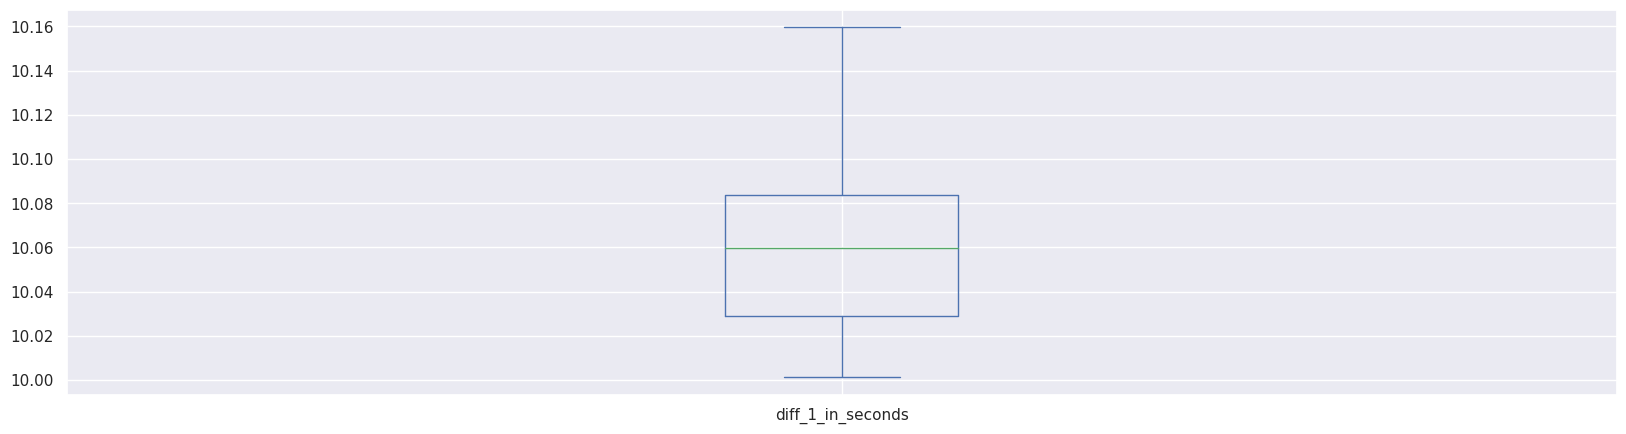

In [22]:
# Compute delay in seconds between `end_download_timestamp` and `timestamp`.
realtime_ohlcv_with_fix_as_is["diff_1_in_seconds"] = (
    realtime_ohlcv_with_fix_as_is["end_download_timestamp"]
    - realtime_ohlcv_with_fix_as_is["timestamp"]
).dt.total_seconds()
_LOG.info(
    "Average delay between `end_download_timestamp` and `timestamp` in seconds is %s, min=%s, max=%s, std=%s",
    round(realtime_ohlcv_with_fix_as_is["diff_1_in_seconds"].mean(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_1_in_seconds"].min(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_1_in_seconds"].max(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_1_in_seconds"].std(), 2),
)
realtime_ohlcv_with_fix_as_is["diff_1_in_seconds"].plot(kind="box")

INFO  Average delay between `knowledge_timestamp` and `timestamp` in seconds is 10.08, min=10.02, max=10.23, std=0.04


<AxesSubplot: >

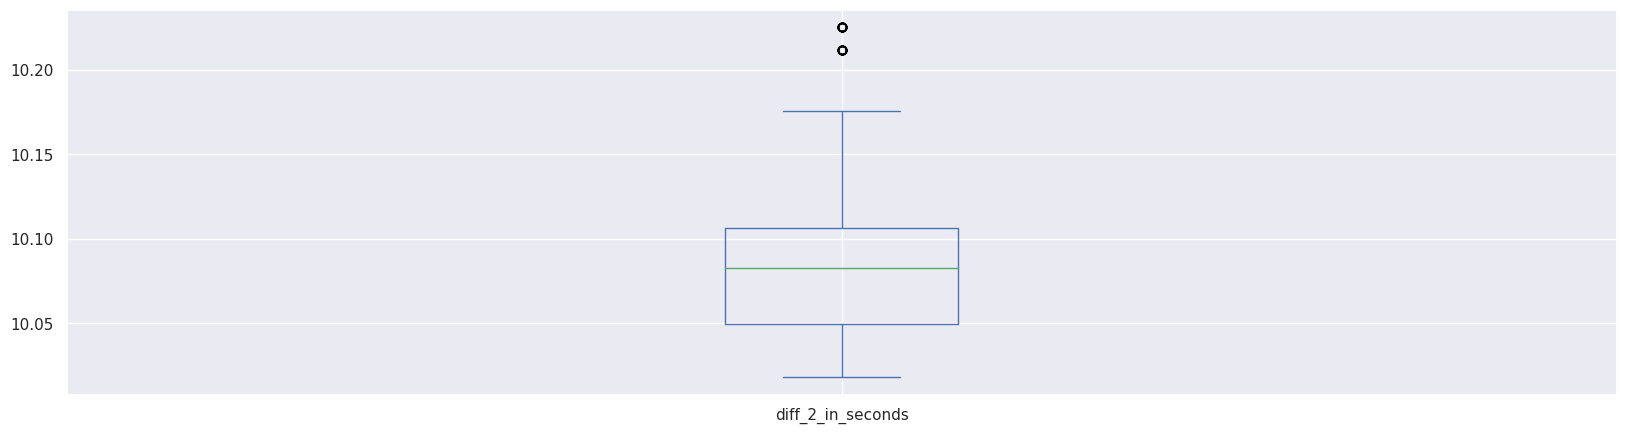

In [23]:
# Compute delay in seconds between `knowledge_timestamp` and `timestamp`.
realtime_ohlcv_with_fix_as_is["diff_2_in_seconds"] = (
    realtime_ohlcv_with_fix_as_is["knowledge_timestamp"]
    - realtime_ohlcv_with_fix_as_is["timestamp"]
).dt.total_seconds()
_LOG.info(
    "Average delay between `knowledge_timestamp` and `timestamp` in seconds is %s, min=%s, max=%s, std=%s",
    round(realtime_ohlcv_with_fix_as_is["diff_2_in_seconds"].mean(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_2_in_seconds"].min(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_2_in_seconds"].max(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_2_in_seconds"].std(), 2),
)
realtime_ohlcv_with_fix_as_is["diff_2_in_seconds"].plot(kind="box")

INFO  Average delay between `knowledge_timestamp` and `end_download_timestamp` in seconds is 0.02, min=0.01, max=0.13, std=0.02


<AxesSubplot: >

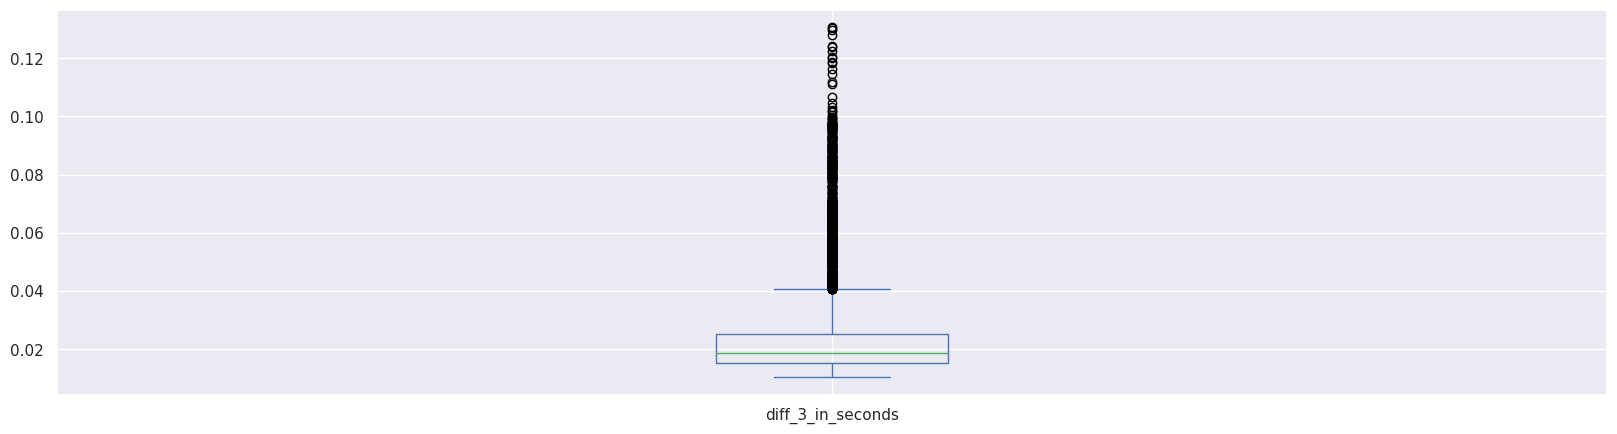

In [24]:
# Compute delay in seconds between `knowledge_timestamp` and `end_download_timestamp`.
realtime_ohlcv_with_fix_as_is["diff_3_in_seconds"] = (
    realtime_ohlcv_with_fix_as_is["knowledge_timestamp"]
    - realtime_ohlcv_with_fix_as_is["end_download_timestamp"]
).dt.total_seconds()
_LOG.info(
    "Average delay between `knowledge_timestamp` and `end_download_timestamp` in seconds is %s, min=%s, max=%s, std=%s",
    round(realtime_ohlcv_with_fix_as_is["diff_3_in_seconds"].mean(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_3_in_seconds"].min(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_3_in_seconds"].max(), 2),
    round(realtime_ohlcv_with_fix_as_is["diff_3_in_seconds"].std(), 2),
)
realtime_ohlcv_with_fix_as_is["diff_3_in_seconds"].plot(kind="box")

### Resampled data with the timing fix

In [25]:
resampled_realtime_ohlcv_with_fix = resample_ohlcv_bars(
    realtime_ohlcv_with_fix, bar_duration
)
_print_df_info(resampled_realtime_ohlcv_with_fix)
resampled_realtime_ohlcv_with_fix.head(3)

INFO  min_timestamp=2023-04-19 00:10:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (7) close high low open twap volume vwap

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2023-04-19 00:10:00-04:00     0.3939    2087.90    30180.5     0.2260      5.621      6.845     0.5257      1.670     24.610     2.2952     0.4009      1.062     0.1340      9.308      8.515     1.1702    0.09299      3.132     0.6934     0.8328     0.5276      4.458     21.017     341.15      2.331     0.3941    2089.71    30184.7     0.2264      5.622      6.846     0.5260      1.672     24.621     2.2964     0.4013      1.065     0.1344      9.309      8.536     1.1706    0.09308      3.140     0.6937     0.8340     0.5278      4.460     21.026     341.24      2.332     0.3932    2084.59    30160.0     0.2257      5.604      6.835     0.5245      1.668     24.529     2.2872     0.4007      1.060     0.1337      9.295      8.507     1.1688    0.09259      3.131     0.6931     0.8328     0.5260      4.455     21.006     340.88      2.329     0.3936    2088.78    30165.8     0.2262      5.616      6.838     0.5250      1.671     24.535     2.2872     0.4012      1.064     0.1344   
2023-04-19 00:15:00-04:00     0.3939    208

The resampled data also matches that from the prod DAG when the timing fix is applied.

In [26]:
diff_df = hpandas.compare_dfs(
    resampled_realtime_ohlcv_with_fix, dag_resample_df_out
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=0.0


# Compare OHLCV data from the prod-like `HistoricalDataSource` with that from the DAG

In [27]:
def _get_prod_market_data(universe_version: str):
    # Get trading universe as asset ids.
    vendor = "CCXT"
    mode = "trade"
    as_full_symbol = True
    full_symbols = ivcu.get_vendor_universe(
        vendor,
        mode,
        version=universe_version,
        as_full_symbol=as_full_symbol,
    )
    asset_ids = [
        ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
    ]
    # Get prod `MarketData`.
    market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(asset_ids)
    return market_data


def load_ohlcv_data_from_historical_datasource(
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
    universe_version: str,
    apply_timing_fix: bool,
) -> pd.DataFrame:
    """
    Load OHLCV data using the prod-like `HistoricalDataSource`.

    :param universe_version: universe version
    :param apply_timing_fix: apply the timing fix if True, otherwise read data as-is
    """
    nid = "read_data"
    market_data = _get_prod_market_data(universe_version)
    ts_col_name = "end_timestamp"
    multiindex_output = True
    col_names_to_remove = None
    historical_data_source = dtfsys.HistoricalDataSource(
        nid,
        market_data,
        ts_col_name,
        multiindex_output,
        col_names_to_remove=col_names_to_remove,
    )
    if apply_timing_fix:
        # Subtract 1 minute to account for the fact that timestamp indicates the start
        # of the bar instead of the end of that.
        start_timestamp = start_timestamp - pd.Timedelta(minutes=1)
        end_timestamp = end_timestamp - pd.Timedelta(minutes=1)
    # Convert to the `dataflow` format.
    fit_intervals = [(start_timestamp, end_timestamp)]
    _LOG.info("fit_intervals=%s", fit_intervals)
    historical_data_source.set_fit_intervals(fit_intervals)
    df_ohlcv = historical_data_source.fit()["df_out"]
    if apply_timing_fix:
        # Add 1 minute back.
        df_ohlcv.index = df_ohlcv.index + pd.Timedelta(minutes=1)
        df_ohlcv["start_timestamp"] = df_ohlcv["start_timestamp"] + pd.Timedelta(
            minutes=1
        )
    return df_ohlcv

## Without the timing fix

In [28]:
appy_timing_fix = False
historical_datasource_df = load_ohlcv_data_from_historical_datasource(
    start_timestamp_ET, end_timestamp_ET, universe_version, appy_timing_fix
)
_print_df_info(historical_datasource_df)
historical_datasource_df.head(3)

/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2023-04-19 00:06:00-0400', tz='America/New_York'), Timestamp('2023-04-19 04:05:00-0400', tz='America/New_York'))]


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (11) asset_id close end_download_timestamp full_symbol high id knowledge_timestamp low open start_timestamp volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                                   end_download_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                       1030828978                       1464553467                       1467591036                       1528092593                       1776791608                       1891737434                       1966583502                       2099673105                       2237530510                       2384892553                       2425308589                       2476706208                       2484635488                       2540896331                       2601760471                       2683705052                       3065029174                       3401245610                       4516629366                       5115052901                       5118394986   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-19 00:06:00-04:00     0.3939    2089.15    30183.1     0.2264      5.609      6.841     0.5253      1.672     24.578     2.2952     0.4012      1.063     0.1342      9.300      8.524     1.1702    0.09285      3.136     0.6934     0.8338     0.5269      4.459     21.020     341.04      2.330 2023-04-19 04:07:10.005245+00:00 2023-04-19 04:07:10.004714+00:00 2023-04-19 04:07:10.004846+00:00 2023-04-19 04:07:10.006179+00:00 2023-04-19 04:07:10.005808+00:00 2023-04-19 04:07:10.005735+00:00 2023-04-19 04:07:10.006312+00:00 2023-04-19 04:07:10.006113+00:00 2023-04-19 04:07:10.006645+00:00 2023-04-19 04:07:10.006381+00:00 2023-04-19 04:07:10.005170+00:00 2023-04-19 04:07:10.006040+00:00 2023-04-19 04:07:10.006516+00:00 2023-04-19 04:07:10.006448+00:00 2023-04-19 04:07:10.005888+00:00 2023-04-19 04:07:10.005584+00:00 2023-04-19 04:07:10.006581+00:00 2023-04-19 04:07:10.005657+00:00 2023-04-19 04:07:10.004932+00:00 2023-04-19 04:07:10.007023+00:00 2023-04-19 04:07:10.005964+00:00   
2023-04-19 00:07:00-04:00     0.3933    208

There is a timing issue when reading data from `HistoricalDataSource`.

In [29]:
columns_to_compare = ["open", "high", "low", "close", "volume"]
diff_df = hpandas.compare_dfs(
    historical_datasource_df[columns_to_compare],
    dag_read_data_df_out[columns_to_compare],
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=1062723435.23008


## With the timing fix

In [30]:
appy_timing_fix = True
historical_datasource_df_with_fix = load_ohlcv_data_from_historical_datasource(
    start_timestamp_ET, end_timestamp_ET, universe_version, appy_timing_fix
)
_print_df_info(historical_datasource_df_with_fix)
historical_datasource_df_with_fix.head(3)

/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2023-04-19 00:05:00-0400', tz='America/New_York'), Timestamp('2023-04-19 04:04:00-0400', tz='America/New_York'))]


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  min_timestamp=2023-04-19 00:06:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (11) asset_id close end_download_timestamp full_symbol high id knowledge_timestamp low open start_timestamp volume

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                                   end_download_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                       1030828978                       1464553467                       1467591036                       1528092593                       1776791608                       1891737434                       1966583502                       2099673105                       2237530510                       2384892553                       2425308589                       2476706208                       2484635488                       2540896331                       2601760471                       2683705052                       3065029174                       3401245610                       4516629366                       5115052901                       5118394986   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-19 00:06:00-04:00     0.3940    2089.71    30184.7     0.2263      5.620      6.843     0.5255      1.672     24.582     2.2934     0.4012      1.065     0.1342      9.301      8.536     1.1705    0.09276      3.138     0.6936     0.8340     0.5268      4.459     21.026     341.11       2.33 2023-04-19 04:06:10.003943+00:00 2023-04-19 04:06:10.003449+00:00 2023-04-19 04:06:10.003572+00:00 2023-04-19 04:06:10.005163+00:00 2023-04-19 04:06:10.004445+00:00 2023-04-19 04:06:10.004376+00:00 2023-04-19 04:06:10.005287+00:00 2023-04-19 04:06:10.005101+00:00 2023-04-19 04:06:10.005596+00:00 2023-04-19 04:06:10.005359+00:00 2023-04-19 04:06:10.003873+00:00 2023-04-19 04:06:10.005026+00:00 2023-04-19 04:06:10.005476+00:00 2023-04-19 04:06:10.005422+00:00 2023-04-19 04:06:10.004841+00:00 2023-04-19 04:06:10.004228+00:00 2023-04-19 04:06:10.005536+00:00 2023-04-19 04:06:10.004300+00:00 2023-04-19 04:06:10.003653+00:00 2023-04-19 04:06:10.006615+00:00 2023-04-19 04:06:10.004955+00:00   
2023-04-19 00:07:00-04:00     0.3939    208

The data matches that from the prod DAG when the timing fix is applied.

In [31]:
columns_to_compare = ["open", "high", "low", "close", "volume"]
diff_df = hpandas.compare_dfs(
    historical_datasource_df_with_fix[columns_to_compare],
    dag_read_data_df_out[columns_to_compare],
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=0.0


## Resampled data with the timing fix

In [32]:
resampled_historical_datasource_df_with_fix = resample_ohlcv_bars(
    historical_datasource_df_with_fix, bar_duration
)
_print_df_info(resampled_historical_datasource_df_with_fix)
resampled_historical_datasource_df_with_fix.head(3)

INFO  min_timestamp=2023-04-19 00:10:00-04:00, max_timestamp=2023-04-19 04:05:00-04:00
INFO  columns=: (7) close high low open twap volume vwap

INFO  assets=: (25) 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573



close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-19 00:10:00-04:00     0.3939    2087.90    30180.5     0.2260      5.621      6.845     0.5257      1.670     24.610     2.2952     0.4009      1.062     0.1340      9.308      8.515     1.1702    0.09299      3.132     0.6934     0.8328     0.5276      4.458     21.017     341.15      2.331     0.3941    2089.71    30184.7     0.2264      5.622      6.846     0.5260      1.672     24.621     2.2964     0.4013      1.065     0.1344      9.309      8.536     1.1706    0.09308      3.140     0.6937     0.8340     0.5278      4.460     21.026     341.24      2.332     0.3932    2084.59    30160.0     0.2257      5.604      6.835     0.5245      1.668     24.529     2.2872     0.4007      1.060     0.1337      9.295      8.507     1.1688    0.09259      3.131     0.6931     0.8328     0.5260      4.455     21.006     340.88      2.329     0.3936    2088.78    30165.8     0.2262      5.616      6.838     0.5250      1.671     24.535     2.2872     0.4012      1.064     0.1344   
2023-04-19 00:15:00-04:00     0.3939    208

The resampled data also matches that from the prod DAG when the timing fix is applied.

In [33]:
diff_df = hpandas.compare_dfs(
    resampled_historical_datasource_df_with_fix, dag_resample_df_out
)
total_abs_diff = diff_df.abs().sum().sum()
_LOG.info("The total absolute difference=%s", total_abs_diff)

INFO  The total absolute difference=0.0
